# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

from tqdm import tqdm

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [36]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [37]:
# The output of torchvision datasets are PIL images in the range [0, 1].
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
#     ]
# )
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [38]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

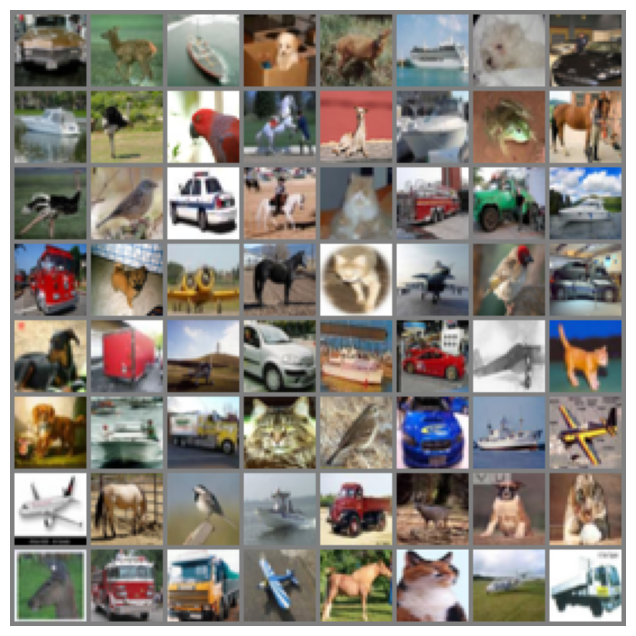

In [39]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network.
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [50]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Your code here!

        # self.convolutional = nn.Sequential(
        #         nn.Conv2d(3, 8, 3, stride=1, padding=1),
        #         nn.ReLU(),
        #         nn.Conv2d(8, 8, 3, stride=1, padding=1),
        #         nn.ReLU(),
        #         nn.MaxPool2d(2, stride=2),
        #         nn.Conv2d(8, 3, 3, stride=1, padding=1),
        #         nn.ReLU(),
        #         nn.Conv2d(3, 3, 3, stride=1, padding=1),
        #         nn.ReLU(),
        #         )

        # self.fully_connected = nn.Sequential(
        #         nn.Linear(16*16*3, 500),
        #         nn.ReLU(),
        #         nn.Linear(500, 10),
        #         nn.Softmax(dim=1))
        self.features = nn.Sequential(
          # First Convolutional Block
          nn.Conv2d(3, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),
          nn.Conv2d(64, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(0.25),

          # Second Convolutional Block
          nn.Conv2d(64, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),
          nn.Conv2d(128, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(0.25),

          # Third Convolutional Block
          nn.Conv2d(128, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
          nn.Conv2d(256, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(0.25),

          PrintSize(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(4*4*256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, self.num_classes)
        )

    def forward(self, x):
        # Your code here!

        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

        return x


model = Model(n_classes)
# device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [51]:
loss_fn = None  # Your code here!
optimizer = None  # Your code here!


In [52]:
# def loss_fn(output, target):
#       output = output.squeeze(1)
#       target = target.float()
#       loss = nn.BCELoss()
#       return loss(output, target)
loss_fn = nn.CrossEntropyLoss()

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)

## Train the network

**Assignment 3:** Finish the training loop below.
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [54]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Size: torch.Size([2, 256, 4, 4])
Output shape: torch.Size([2, 10])
Output logits:
[[-0.87470937  0.3062513   0.1957609  -0.56971794 -0.99864614 -0.87044734
  -0.43343496 -0.04518096  0.55812687  0.271018  ]
 [ 1.0726173   0.10649596 -0.68913025 -0.52377605 -0.18561979 -1.8007582
  -0.4800313   0.31949133  0.33578673  0.56310326]]
Output probabilities:
[[0.0462946  0.15080474 0.1350298  0.06280387 0.0408983  0.04649233
  0.07197362 0.1061182  0.19400065 0.14558391]
 [0.25922963 0.09865145 0.04452125 0.05252666 0.07366127 0.01464851
  0.05487543 0.12206922 0.12407468 0.15574192]]


In [55]:
batch_size = 64
num_epochs = 50
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

# def loss_fn(output, target):
#       # output = output.unsqueeze(1)
#       # target = target.float()

#       target = target.unsqueeze(1)

#       print("output")
#       print(output.shape)
#       print("target")
#       print(target.shape)

#       print("output:")
#       print(output[0])

#       loss = nn.BCELoss()
#       return loss(output, target)

# def loss_fn(output, target):
#         return F.nll_loss(torch.log(output), target)

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!


        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(inputs)
        #Compute the loss
        loss = loss_fn(output, targets)

        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()

        # train_loss.append(loss.item())

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in tqdm(test_loader):
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

 64%|██████▍   | 503/782 [00:19<01:25,  3.27it/s]

Step 500     training accuracy: 0.52725
             test accuracy: 0.6214


 29%|██▊       | 223/782 [00:10<01:53,  4.94it/s]

Step 1000    training accuracy: 0.7178182339449541
             test accuracy: 0.7311


 92%|█████████▏| 721/782 [00:30<00:18,  3.36it/s]

Step 1500    training accuracy: 0.7360625
             test accuracy: 0.7613


 56%|█████▌    | 439/782 [00:17<01:35,  3.61it/s]

Step 2000    training accuracy: 0.7713947821100917
             test accuracy: 0.789


 20%|██        | 159/782 [00:08<02:52,  3.61it/s]

Step 2500    training accuracy: 0.8050933441558441
             test accuracy: 0.8031


 84%|████████▍ | 659/782 [00:27<00:27,  4.49it/s]

Step 3000    training accuracy: 0.805
             test accuracy: 0.7952


 48%|████▊     | 377/782 [00:15<01:28,  4.57it/s]

Step 3500    training accuracy: 0.8285450268817204
             test accuracy: 0.8054


 12%|█▏        | 95/782 [00:06<02:37,  4.37it/s]

Step 4000    training accuracy: 0.8461805555555556
             test accuracy: 0.8297


 76%|███████▌  | 596/782 [00:26<00:42,  4.34it/s]

Step 4500    training accuracy: 0.84159375
             test accuracy: 0.8369


 40%|███▉      | 311/782 [00:13<02:24,  3.26it/s]

Step 5000    training accuracy: 0.8612012987012987
             test accuracy: 0.8372


  4%|▍         | 32/782 [00:04<02:43,  4.59it/s]

Step 5500    training accuracy: 0.8743990384615384
             test accuracy: 0.8529


 68%|██████▊   | 529/782 [00:23<01:07,  3.76it/s]

Step 6000    training accuracy: 0.8706875
             test accuracy: 0.8356


 32%|███▏      | 247/782 [00:11<01:59,  4.48it/s]

Step 6500    training accuracy: 0.8790343237704918
             test accuracy: 0.8446


 96%|█████████▌| 747/782 [00:31<00:09,  3.68it/s]

Step 7000    training accuracy: 0.87578125
             test accuracy: 0.8474


 60%|█████▉    | 466/782 [00:17<01:09,  4.56it/s]

Step 7500    training accuracy: 0.8874797077922078
             test accuracy: 0.8438


 23%|██▎       | 183/782 [00:09<02:41,  3.72it/s]

Step 8000    training accuracy: 0.9078125
             test accuracy: 0.8639


 87%|████████▋ | 683/782 [00:28<00:21,  4.56it/s]

Step 8500    training accuracy: 0.8885
             test accuracy: 0.8574


 51%|█████▏    | 401/782 [00:16<02:12,  2.88it/s]

Step 9000    training accuracy: 0.9041300251256281
             test accuracy: 0.8432


 15%|█▌        | 119/782 [00:06<02:25,  4.54it/s]

Step 9500    training accuracy: 0.9113685344827587
             test accuracy: 0.8483


 79%|███████▉  | 620/782 [00:26<00:49,  3.29it/s]

Step 10000   training accuracy: 0.9061875
             test accuracy: 0.8647


 43%|████▎     | 338/782 [00:14<01:37,  4.54it/s]

Step 10500   training accuracy: 0.9185535179640718
             test accuracy: 0.8638


  7%|▋         | 57/782 [00:06<03:50,  3.15it/s]

Step 11000   training accuracy: 0.9278846153846154
             test accuracy: 0.8653


 71%|███████   | 555/782 [00:25<00:51,  4.42it/s]

Step 11500   training accuracy: 0.91771875
             test accuracy: 0.8674


 35%|███▍      | 273/782 [00:12<02:28,  3.43it/s]

Step 12000   training accuracy: 0.9274305555555555
             test accuracy: 0.8716


 99%|█████████▉| 774/782 [00:31<00:01,  4.32it/s]

Step 12500   training accuracy: 0.91409375
             test accuracy: 0.8579


 63%|██████▎   | 489/782 [00:20<01:39,  2.95it/s]

Step 13000   training accuracy: 0.9250768442622951
             test accuracy: 0.865


 27%|██▋       | 211/782 [00:10<02:48,  3.39it/s]

Step 13500   training accuracy: 0.9355279126213593
             test accuracy: 0.867


 91%|█████████ | 710/782 [00:30<00:18,  4.00it/s]

Step 14000   training accuracy: 0.92021875
             test accuracy: 0.8728


 55%|█████▍    | 427/782 [00:17<01:46,  3.33it/s]

Step 14500   training accuracy: 0.93359375
             test accuracy: 0.8677


 19%|█▉        | 147/782 [00:09<02:59,  3.53it/s]

Step 15000   training accuracy: 0.9388204225352113
             test accuracy: 0.8765


 83%|████████▎ | 647/782 [00:28<00:30,  4.42it/s]

Step 15500   training accuracy: 0.92909375
             test accuracy: 0.8689


 47%|████▋     | 364/782 [00:15<01:55,  3.61it/s]

Step 16000   training accuracy: 0.9366753472222222
             test accuracy: 0.8497


 11%|█         | 84/782 [00:06<02:28,  4.69it/s]

Step 16500   training accuracy: 0.9417067307692307
             test accuracy: 0.8725


 75%|███████▍  | 583/782 [00:26<01:01,  3.26it/s]

Step 17000   training accuracy: 0.932
             test accuracy: 0.8565


 38%|███▊      | 300/782 [00:13<01:51,  4.33it/s]

Step 17500   training accuracy: 0.9407200168918919
             test accuracy: 0.8739


  2%|▏         | 17/782 [00:04<03:41,  3.45it/s]

Step 18000   training accuracy: 0.9486607142857143
             test accuracy: 0.8766


 66%|██████▌   | 518/782 [00:23<01:05,  4.02it/s]

Step 18500   training accuracy: 0.93846875
             test accuracy: 0.8689


 30%|███       | 235/782 [00:11<02:41,  3.38it/s]

Step 19000   training accuracy: 0.9428879310344828
             test accuracy: 0.8739


 94%|█████████▍| 737/782 [00:31<00:12,  3.51it/s]

Step 19500   training accuracy: 0.93071875
             test accuracy: 0.8705


 58%|█████▊    | 455/782 [00:18<01:17,  4.21it/s]

Step 20000   training accuracy: 0.9410069444444444
             test accuracy: 0.8761


 22%|██▏       | 173/782 [00:09<03:04,  3.30it/s]

Step 20500   training accuracy: 0.9500558035714286
             test accuracy: 0.8796


 86%|████████▌ | 671/782 [00:28<00:31,  3.47it/s]

Step 21000   training accuracy: 0.937625
             test accuracy: 0.8697


 50%|████▉     | 390/782 [00:16<02:02,  3.20it/s]

Step 21500   training accuracy: 0.9460006476683938
             test accuracy: 0.8716


 14%|█▎        | 107/782 [00:06<02:33,  4.38it/s]

Step 22000   training accuracy: 0.9450120192307693
             test accuracy: 0.8763


 78%|███████▊  | 607/782 [00:26<00:49,  3.50it/s]

Step 22500   training accuracy: 0.94075
             test accuracy: 0.8827


 42%|████▏     | 326/782 [00:13<01:45,  4.34it/s]

Step 23000   training accuracy: 0.9481754658385093
             test accuracy: 0.8726


  5%|▌         | 43/782 [00:04<02:52,  4.29it/s]

Step 23500   training accuracy: 0.95703125
             test accuracy: 0.8807


 70%|██████▉   | 544/782 [00:24<00:58,  4.04it/s]

Step 24000   training accuracy: 0.94484375
             test accuracy: 0.8699


 33%|███▎      | 261/782 [00:11<01:58,  4.40it/s]

Step 24500   training accuracy: 0.9464631782945736
             test accuracy: 0.8744


 97%|█████████▋| 760/782 [00:31<00:07,  2.90it/s]

Step 25000   training accuracy: 0.9411875
             test accuracy: 0.874


 61%|██████▏   | 479/782 [00:18<01:08,  4.41it/s]

Step 25500   training accuracy: 0.9486607142857143
             test accuracy: 0.8746


 25%|██▌       | 199/782 [00:10<02:47,  3.48it/s]

Step 26000   training accuracy: 0.9517557989690721
             test accuracy: 0.8842


 89%|████████▉ | 698/782 [00:30<00:19,  4.33it/s]

Step 26500   training accuracy: 0.94115625
             test accuracy: 0.8685


 53%|█████▎    | 416/782 [00:17<01:55,  3.17it/s]

Step 27000   training accuracy: 0.9478534587378641
             test accuracy: 0.8819


 17%|█▋        | 135/782 [00:07<02:29,  4.34it/s]

Step 27500   training accuracy: 0.9538461538461539
             test accuracy: 0.882


 81%|████████  | 633/782 [00:27<00:43,  3.40it/s]

Step 28000   training accuracy: 0.94578125
             test accuracy: 0.8715


 45%|████▍     | 350/782 [00:14<02:10,  3.31it/s]

Step 28500   training accuracy: 0.9510147270114943
             test accuracy: 0.8771


  9%|▉         | 70/782 [00:05<02:47,  4.25it/s]

Step 29000   training accuracy: 0.9493371212121212
             test accuracy: 0.8809


 73%|███████▎  | 569/782 [00:26<01:15,  2.83it/s]

Step 29500   training accuracy: 0.94746875
             test accuracy: 0.8708


 37%|███▋      | 288/782 [00:12<01:53,  4.36it/s]

Step 30000   training accuracy: 0.9546104753521126
             test accuracy: 0.8853


  1%|          | 5/782 [00:04<09:30,  1.36it/s]

Step 30500   training accuracy: 0.9453125
             test accuracy: 0.8803


 65%|██████▍   | 507/782 [00:24<01:04,  4.29it/s]

Step 31000   training accuracy: 0.94909375
             test accuracy: 0.8785


 29%|██▊       | 224/782 [00:11<02:54,  3.20it/s]

Step 31500   training accuracy: 0.9553267045454545
             test accuracy: 0.8819


 92%|█████████▏| 723/782 [00:30<00:13,  4.31it/s]

Step 32000   training accuracy: 0.94296875
             test accuracy: 0.8793


 57%|█████▋    | 442/782 [00:17<01:20,  4.24it/s]

Step 32500   training accuracy: 0.951769406392694
             test accuracy: 0.8768


 20%|██        | 159/782 [00:08<02:36,  3.98it/s]

Step 33000   training accuracy: 0.9517227564102564
             test accuracy: 0.8823


 84%|████████▍ | 659/782 [00:28<00:35,  3.44it/s]

Step 33500   training accuracy: 0.94409375
             test accuracy: 0.8793


 48%|████▊     | 376/782 [00:16<02:24,  2.81it/s]

Step 34000   training accuracy: 0.9518298796791443
             test accuracy: 0.8781


 12%|█▏        | 95/782 [00:06<02:36,  4.39it/s]

Step 34500   training accuracy: 0.95703125
             test accuracy: 0.8824


 76%|███████▌  | 596/782 [00:26<00:50,  3.67it/s]

Step 35000   training accuracy: 0.9500625
             test accuracy: 0.8847


 40%|████      | 313/782 [00:13<01:49,  4.30it/s]

Step 35500   training accuracy: 0.9553931451612904
             test accuracy: 0.8806


  4%|▍         | 33/782 [00:05<04:04,  3.06it/s]

Step 36000   training accuracy: 0.9536830357142857
             test accuracy: 0.8815


 68%|██████▊   | 531/782 [00:24<00:57,  4.38it/s]

Step 36500   training accuracy: 0.951125
             test accuracy: 0.8805


 32%|███▏      | 250/782 [00:11<02:35,  3.42it/s]

Step 37000   training accuracy: 0.9556021341463414
             test accuracy: 0.8822


 96%|█████████▌| 748/782 [00:31<00:10,  3.20it/s]

Step 37500   training accuracy: 0.94534375
             test accuracy: 0.885


 60%|█████▉    | 467/782 [00:18<01:33,  3.38it/s]

Step 38000   training accuracy: 0.9517106681034483
             test accuracy: 0.8791


 24%|██▎       | 184/782 [00:09<03:24,  2.93it/s]

Step 38500   training accuracy: 0.9534684065934066
             test accuracy: 0.8837


 88%|████████▊ | 685/782 [00:29<00:28,  3.36it/s]

Step 39000   training accuracy: 0.9448125
             test accuracy: 0.8856


100%|██████████| 782/782 [00:32<00:00, 23.96it/s]

Finished training.


## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

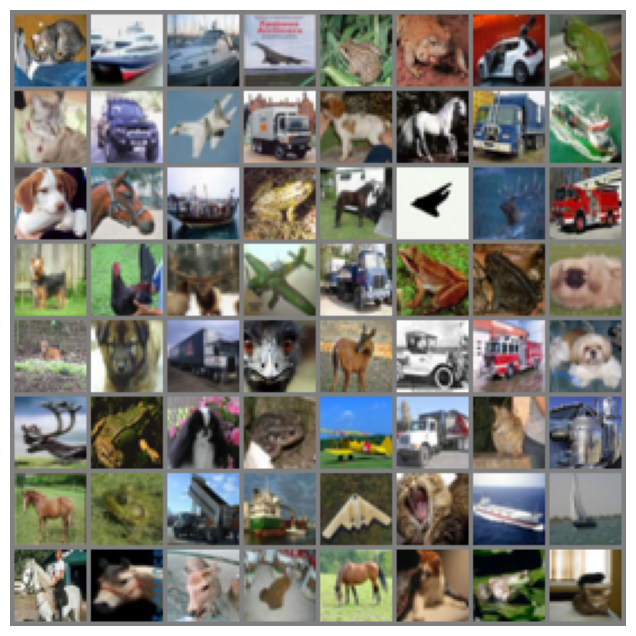

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          bird     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          ship     
    truck         truck    
     dog           dog     
    bird          bird     
    deer          bird     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog           cat     
     dog           dog     
    deer          bird     
     dog           d

In [56]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [57]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)

    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [58]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.884


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


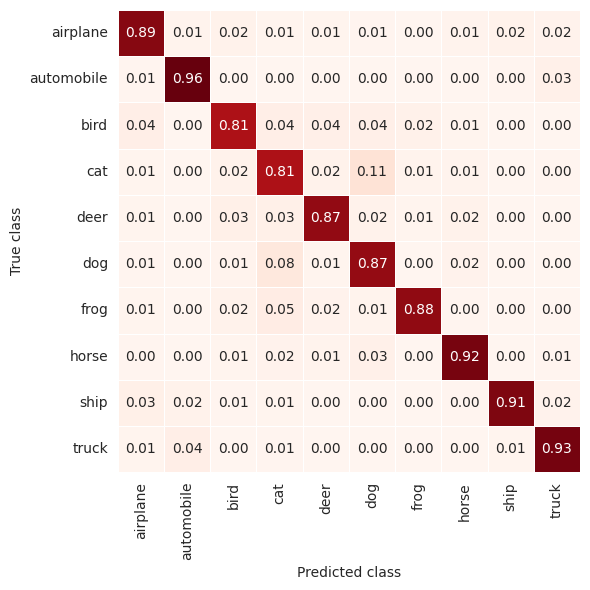

In [59]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

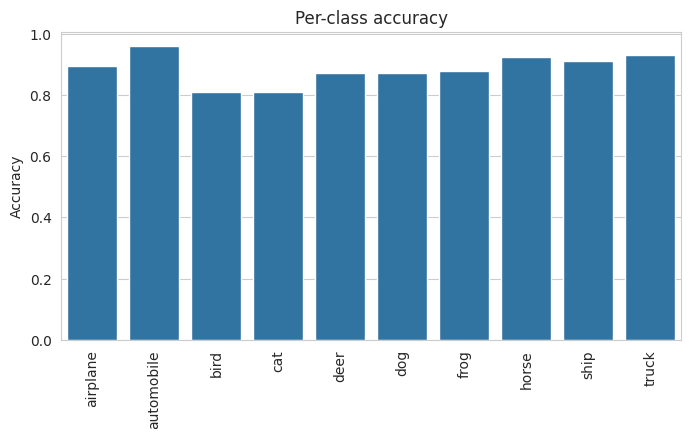

In [60]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:**
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

Using hints, I started with a small number of epochs to speed up hyperparameter tuning. When I noticed that the score wasn't reaching a plateau within the given epoch range, I recognized it as a good indication for adjusting the hyperparameter values. In this process, I referred to Michael Nielsen's book, specifically Chapter 3 - How to choose a neural network's hyper-parameters? The learning rate made the biggest difference.

3. Write down key lessons/insights you got during this exercise.

Use a GPU whenever possible. The Adam optimizer performed better than SGD. It’s important to select the correct padding and stride to ensure that convolutions don't reduce the image size too much, as this can result in losing important features.

**Answer:**

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [61]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['Tesla T4']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**



